In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients

from sklearn.decomposition import PCA

In [2]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T

#data pre-processing
scaler = StandardScaler()
data_standard = scaler.fit_transform(data)

#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

# Support Vector Regression

In [7]:
# SVR regression
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
predict=svr_rbf.fit(X_train, y_train).predict(X_test)

In [8]:
r=r2_score(y_test,predict)
print(r)
MSE = mean_squared_error(y_test,predict)
print(MSE)
MAPE = mean_absolute_percentage_error(y_test,predict)
print(MAPE)

0.942670352282454
17.00290775151631
0.0068921458359114144


Text(0.5, 1.0, 'Support Vector Regression')

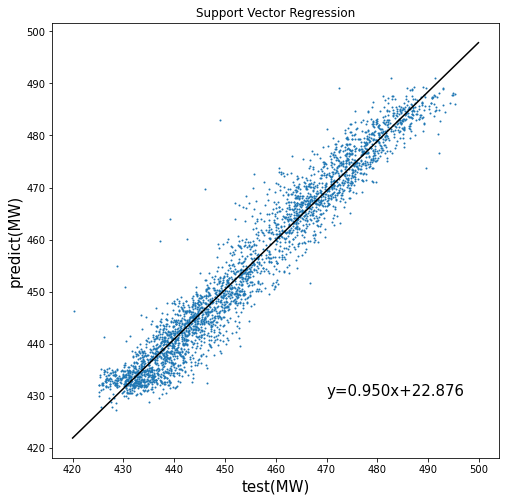

In [9]:
n=len(predict)

t = np.linspace(1,n,n)
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,predict,s=1)
z5 = np.polyfit(y_test,predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
plt.text(470,430,'y=%.3fx+%.3f'%(z5[0],z5[1]),fontsize=15)
plt.title('Support Vector Regression')

# Neural Network

In [10]:
x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
y_ts=y_ts.reshape(6410,1)
y_test_ts = y_test_ts.reshape(3158,1)
x=Variable(x_ts)

In [11]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(4,8) 
        self.linear2 = torch.nn.Linear(8,6)
        self.predict = torch.nn.Linear(6,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()
model_pca = Model().double()

model

Model(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [12]:
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []
for epoch in range(1000):
    # forward
    y_pred = model(x)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_list.append(epoch)
    l_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    
    # updating parameters
    optimizer.step()

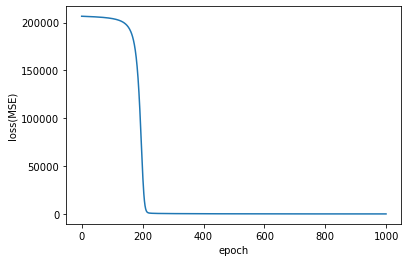

In [13]:
plt.plot(h_list, l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.8991744835262878
MSE is 29.902973833848232


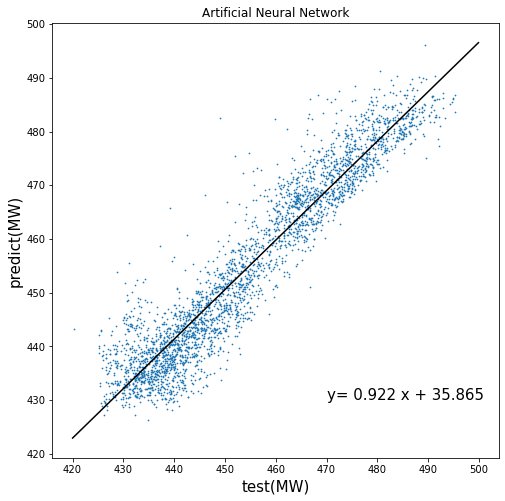

In [14]:
y_test_model=model(x_test_ts)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,y_predict,s=0.5)

z5 = np.polyfit(y_test,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_test,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

# Fast Gradient Sign Method (FGSM)

In [15]:
def FGSM_attack(x_test_ts, y_test_ts, level):
    x_test_ts = Variable(x_test_ts,requires_grad=True)
    zero_gradients(x_test_ts)
    y_test_model=model(x_test_ts)
    loss = loss_func(y_test_ts,y_test_model)
    loss.backward()
    normed_grad = level * torch.sign(x_test_ts.grad.data)
    x_adv_ts = x_test_ts.data + normed_grad
    y_adv_ts = model(x_adv_ts)
    return x_adv_ts, y_adv_ts
    


In [16]:
levels = [0.001, 0.01,0.05,0.1,0.2,0.3]

#y_ts=y_ts.reshape(3158,1)

train_scores = []
test_scores = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    y_p1 = y_adv_ts.detach().numpy()    
    r=r2_score(y_test,y_p1)
    train_scores.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,y_ts,level)
    y_p2 = y_adv_tr.detach().numpy()    
    r=r2_score(y_train,y_p2)
    test_scores.append(r)
    

Text(0.5, 1.0, 'Attack on ANN')

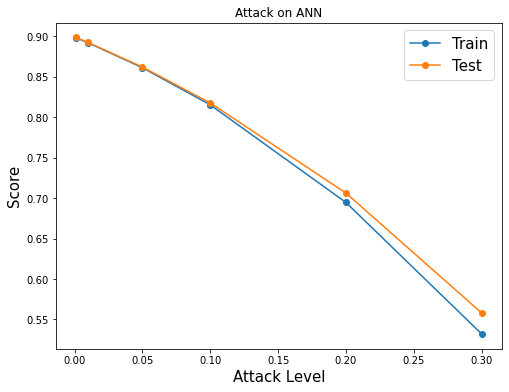

In [17]:
plt.figure(figsize=(8,6))
plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(levels, test_scores, label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("Attack on ANN")


# PCA Defense

In [18]:
class Model_pca(torch.nn.Module):
    def __init__(self):
        super(Model_pca,self).__init__()
        self.linear1 = torch.nn.Linear(3,12) 
        self.linear2 = torch.nn.Linear(12,8)
        self.predict = torch.nn.Linear(8,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    

model_pca = Model_pca().double()
model_pca_svr = Model_pca().double()

model_pca_svr

Model_pca(
  (linear1): Linear(in_features=3, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=8, bias=True)
  (predict): Linear(in_features=8, out_features=1, bias=True)
)

In [19]:
def train_model_pca(x_train,model):
    pca = PCA(n_components=3)

    pca.fit(X_train)
    x_tr_pca = pca.fit_transform(X_train)
    x_tr_pca=torch.from_numpy(x_tr_pca)
    
    optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
    loss_func = torch.nn.MSELoss()

    h_list = []
    l_list = []
    for epoch in range(9000):
        # forward
        y_pred = model_pca(x_tr_pca)
        loss = loss_func(y_pred,y_ts)
       # print(epoch, loss.item())
        h_list.append(epoch)
        l_list.append(loss.item())
    
        # back propagation
        optimizer.zero_grad()
        loss.backward()
    
        # updating parameters
        optimizer.step()
    return h_list,l_list,model,x_tr_pca
    
[h_list_pca,l_list_pca,model_pca,x_tr_pca]=train_model_pca(X_train,model_pca)

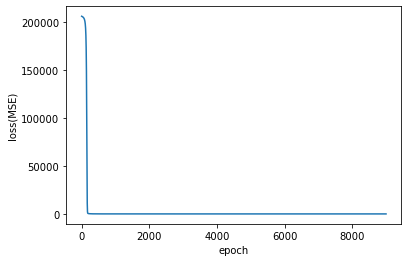

In [20]:
plt.plot(h_list_pca, l_list_pca)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

0.9080240868350922
MSE is 27.27834600710054


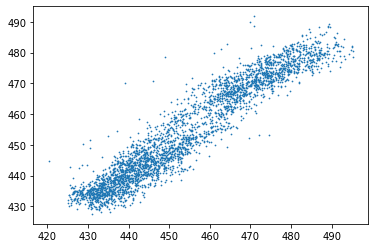

In [21]:
pca = PCA(n_components=3)
pca.fit(X_test)
x_te_pca = pca.fit_transform(X_test)
x_te_pca=torch.from_numpy(x_te_pca)
y_test_model=model_pca(x_te_pca)
y_predict=y_test_model.detach().numpy()
plt.scatter(y_test,y_predict,s=0.5)
r=r2_score(y_test,y_predict)
print(r)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

In [22]:

train_scores_pca = []
test_scores_pca = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,y_test_ts,level)
    pca.fit(x_adv_ts)
    x_te_pca = pca.fit_transform(x_adv_ts)
    x_te_pca=torch.from_numpy(x_te_pca)
    y_p1 = model_pca(x_te_pca)
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_test,y_p1)
    test_scores_pca.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,y_ts,level)
    pca.fit(x_adv_tr)
    x_tr_pca = pca.fit_transform(x_adv_tr)
    x_tr_pca=torch.from_numpy(x_tr_pca)
    y_p2 = model_pca(x_tr_pca)
    y_p2 = y_p2.detach().numpy()    
    r=r2_score(y_train,y_p2)
    train_scores_pca.append(r)
    
print(x_ts)
print(x_adv_tr)

tensor([[-0.5664, -1.2375,  0.5592,  0.5384],
        [-0.3088, -1.1478, -1.7276, -0.5952],
        [-1.7661, -0.8386,  1.2042, -0.0362],
        ...,
        [ 0.6185,  1.0533, -0.8048, -0.4499],
        [ 0.9526,  0.8251,  0.7630, -1.3013],
        [ 0.0710, -0.8559, -0.3282, -0.5616]], dtype=torch.float64)
tensor([[-0.8664, -1.5375,  0.8592,  0.2384],
        [-0.6088, -1.4478, -1.4276, -0.8952],
        [-1.4661, -0.5386,  0.9042,  0.2638],
        ...,
        [ 0.3185,  0.7533, -0.5048, -0.7499],
        [ 1.2526,  1.1251,  0.4630, -1.0013],
        [-0.2290, -1.1559, -0.0282, -0.8616]], dtype=torch.float64)


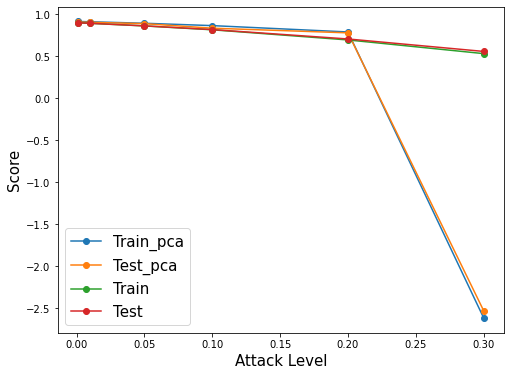

In [23]:
plt.figure(figsize=(8,6))
plt.plot(levels, train_scores_pca, label="Train_pca",marker='o');
plt.plot(levels, test_scores_pca, label="Test_pca",marker='o');
plt.plot(levels, train_scores, label="Train",marker='o');
plt.plot(levels, test_scores, label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})

In [24]:
print(test_scores_pca)
print(train_scores_pca)

[0.907687739276365, 0.9045639417561214, 0.888489028556357, 0.8345662655020301, 0.7789794761704667, -2.528592615263393]
[0.9145480225497269, 0.9110836616948347, 0.8932137900511904, 0.8651713222810666, 0.7897031239598453, -2.6144686820486434]


# Attack on SVR

In [25]:
print(predict)
pre_svr = torch.tensor(predict)
pre_svr = Variable(pre_svr).reshape(3158,1)
yTr_svr = torch.tensor(y_train).reshape(6410,1)
yTr_svr = Variable(yTr_svr)

[464.45383374 485.72389328 465.11126527 ... 453.74027866 466.99450342
 450.25560017]


In [26]:
#Implement FGSM attack
levels = [0.001, 0.01,0.05,0.1,0.2,0.3]

#y_ts=y_ts.reshape(3158,1)

train_scores_svr = []
test_scores_svr = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,pre_svr,level)
    y_p1 = y_adv_ts.detach().numpy()    
    r=r2_score(y_test,y_p1)
    train_scores_svr.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,yTr_svr,level)
    y_p2 = y_adv_tr.detach().numpy()    
    r=r2_score(y_train,y_p2)
    test_scores_svr.append(r)

Text(0.5, 1.0, 'FGSM attack on SVR')

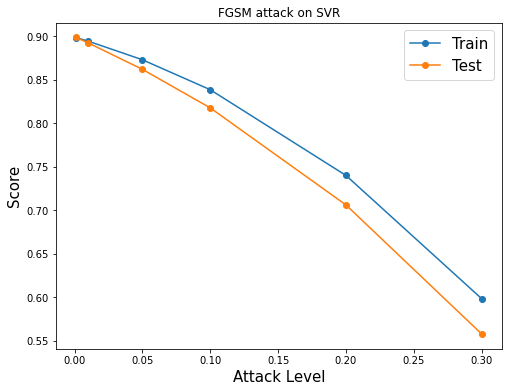

In [27]:
plt.figure(figsize=(8,6))
plt.plot(levels, train_scores_svr, label="Train",marker='o');
plt.plot(levels, test_scores_svr, label="Test",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("FGSM attack on SVR")

In [28]:
train_scores_pca_svr = []
test_scores_pca_svr = []


for level in levels:
    x_adv_ts, y_adv_ts = FGSM_attack(x_test_ts,pre_svr,level)# Note the same attack method with input data from SVR
    pca.fit(x_adv_ts)
    x_te_pca = pca.fit_transform(x_adv_ts)
    x_te_pca=torch.from_numpy(x_te_pca)
    y_p1 = model_pca(x_te_pca) # same PCA model as in the attack on ANN
    y_p1 = y_p1.detach().numpy()    
    r=r2_score(y_test,y_p1)
    test_scores_pca_svr.append(r)
    
    x_adv_tr, y_adv_tr = FGSM_attack(x_ts,yTr_svr,level)
    pca.fit(x_adv_tr)
    x_tr_pca = pca.fit_transform(x_adv_tr)
    x_tr_pca=torch.from_numpy(x_tr_pca)
    y_p2 = model_pca(x_tr_pca)
    y_p2 = y_p2.detach().numpy()    
    r=r2_score(y_train,y_p2)
    train_scores_pca_svr.append(r)
    
print(x_ts)
print(x_adv_tr)

tensor([[-0.5664, -1.2375,  0.5592,  0.5384],
        [-0.3088, -1.1478, -1.7276, -0.5952],
        [-1.7661, -0.8386,  1.2042, -0.0362],
        ...,
        [ 0.6185,  1.0533, -0.8048, -0.4499],
        [ 0.9526,  0.8251,  0.7630, -1.3013],
        [ 0.0710, -0.8559, -0.3282, -0.5616]], dtype=torch.float64)
tensor([[-0.8664, -1.5375,  0.8592,  0.2384],
        [-0.6088, -1.4478, -1.4276, -0.8952],
        [-1.4661, -0.5386,  0.9042,  0.2638],
        ...,
        [ 0.3185,  0.7533, -0.5048, -0.7499],
        [ 1.2526,  1.1251,  0.4630, -1.0013],
        [-0.2290, -1.1559, -0.0282, -0.8616]], dtype=torch.float64)


Text(0.5, 1.0, 'FGSM attack on SVR')

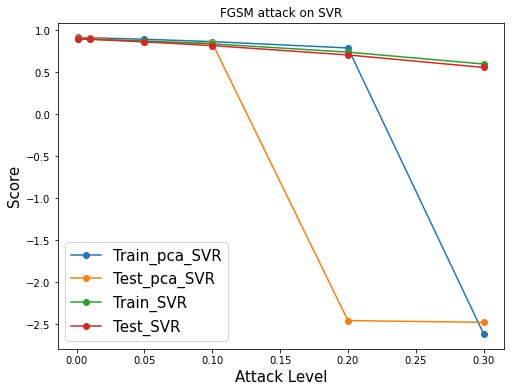

In [29]:
plt.figure(figsize=(8,6))
plt.plot(levels, train_scores_pca_svr, label="Train_pca_SVR",marker='o');
plt.plot(levels, test_scores_pca_svr, label="Test_pca_SVR",marker='o');
plt.plot(levels, train_scores_svr, label="Train_SVR",marker='o');
plt.plot(levels, test_scores_svr, label="Test_SVR",marker='o');
plt.xlabel("Attack Level",fontsize=15);
plt.ylabel("Score",fontsize=15);
plt.legend(prop={'size': 15})
plt.title("FGSM attack on SVR")

# Jacobian-based Saliency Map Attack

In [ ]:
def JSMA_attack(x_test_ts, y_test_ts, level):
    x_test_ts = Variable(x_test_ts,requires_grad=True)
    zero_gradients(x_test_ts)
    y_test_model=model(x_test_ts)
    loss = loss_func(y_test_ts,y_test_model)
    loss.backward()
    normed_grad = level * torch.sign(x_test_ts.grad.data)
    x_adv_ts = x_test_ts.data + normed_grad
    y_adv_ts = model(x_adv_ts)
    return x_adv_ts, y_adv_ts